In [16]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce
from tqdm import tqdm

from pywt import dwt2
import math
from scipy import ndimage
from sklearn.cluster import KMeans


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter
from segmentation import Segmentation


import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()
seg = Segmentation()



plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [17]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths[8]

('mms', '..\\dataset\\output\\mms')

Preparing a dataframe to summarize the dataset

In [18]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
29,positives,22580393_5eae9beae14d26fd_MG_R_ML_ANON.tif
230,negatives,27829215_fbb55bf7fff48540_MG_L_ML_ANON.tif
346,negatives,51049462_6f64793857feb5d0_MG_L_ML_ANON.tif
253,negatives,50994110_cc9e66c5b31baab8_MG_L_ML_ANON.tif
57,positives,22678646_61b13c59bcba149e_MG_L_CC_ANON.tif
264,negatives,50994706_069212ec65a94339_MG_R_CC_ANON.tif
172,negatives,22670978_f571fd4e63c718e3_MG_L_CC_ANON.tif
75,positives,30011507_349323117bf0fd93_MG_L_CC_ANON.tif
355,negatives,53580638_40e22f2e3215b954_MG_R_ML_ANON.tif
8,positives,20587902_8dbbd4e51f549ff0_MG_R_CC_ANON.tif


Dataset Summary

In [19]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [20]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

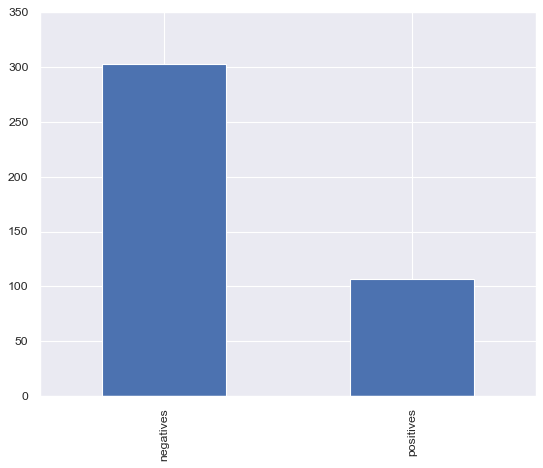

In [21]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

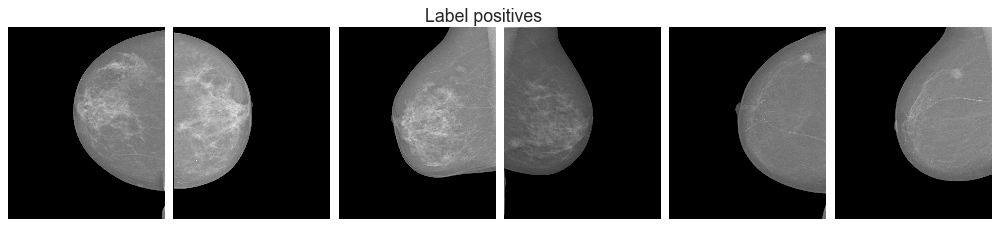

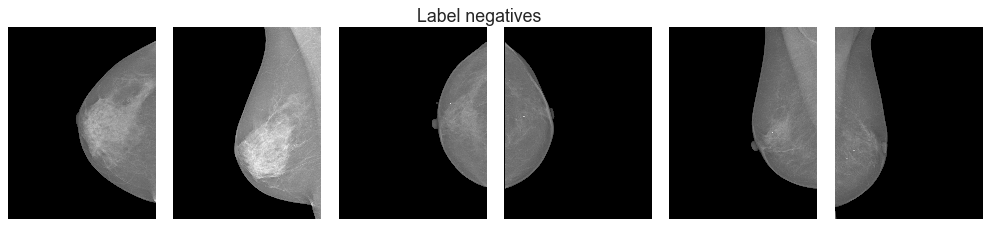

In [22]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

In [23]:
# print(dataset_folder_paths[])
# print(dataset_folder_paths[0][1])
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('negative_images', '..\\dataset\\negative_images'),
 ('output', '..\\dataset\\output'),
 ('features', '..\\dataset\\output\\features'),
 ('final', '..\\dataset\\output\\features\\final'),
 ('kmeans', '..\\dataset\\output\\kmeans'),
 ('mms', '..\\dataset\\output\\mms'),
 ('segmentation', '..\\dataset\\output\\segmentation'),
 ('segmentation-regions', '..\\dataset\\output\\segmentation-regions'),
 ('upsampled', '..\\dataset\\output\\upsampled'),
 ('groundtruth', '..\\dataset\\output\\upsampled\\groundtruth'),
 ('segmentation', '..\\dataset\\output\\upsampled\\segmentation'),
 ('overlay', '..\\dataset\\overlay'),
 ('positive_images', '..\\dataset\\positive_images'),
 ('processed', '..\\dataset\\processed'),
 ('cropped_raw', '..\\dataset\\processed\\cropped_raw'),
 ('groundtruth', '..\\dataset\\processed\\groundtruth'),
 ('positive_images', '..\\dataset\\processed\\positive

2023-05-24 10:36:40.375 | INFO     | preprocessing:fit:150 - Started processing pipeline.
100%|█████████████████████████| 1/1 [00:00<00:00,  6.56it/s]
2023-05-24 10:36:40.535 | INFO     | preprocessing:fit:215 - Finished processing 303 files in approximately 0.159 seconds.


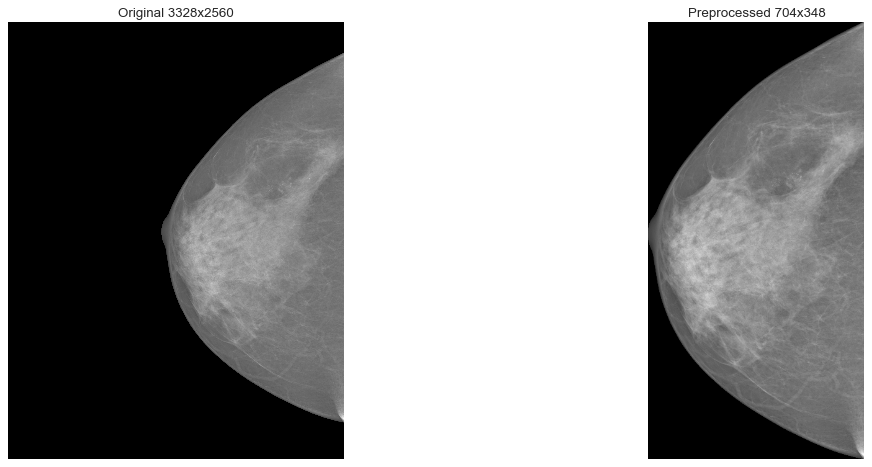

In [41]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path='..\\dataset\\negative_images',
                 ground_truth_path = '..\\dataset\\groundtruth',
                 process_n=1, 
                 plot=True, 
                 export_processed=False)

## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

1. Multi-scale Morphological Sifters

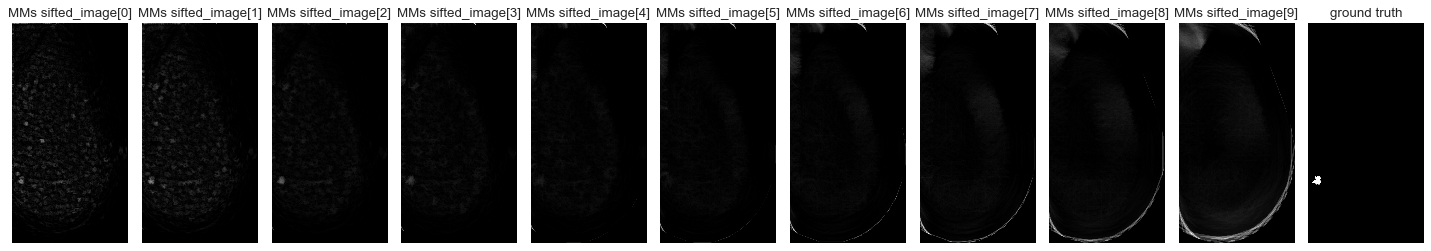

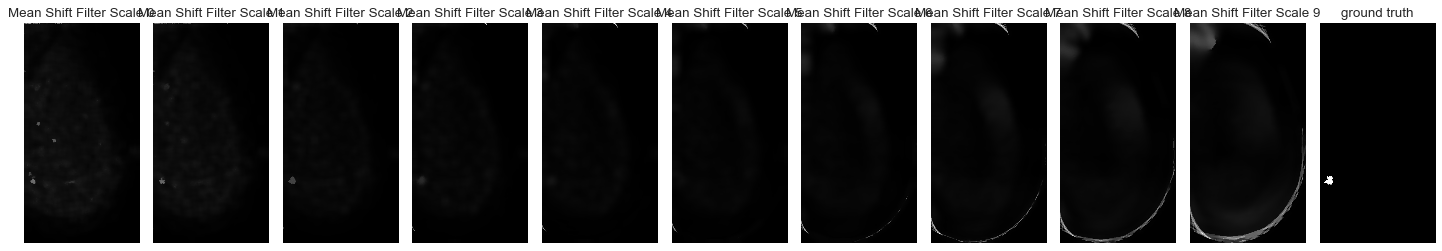

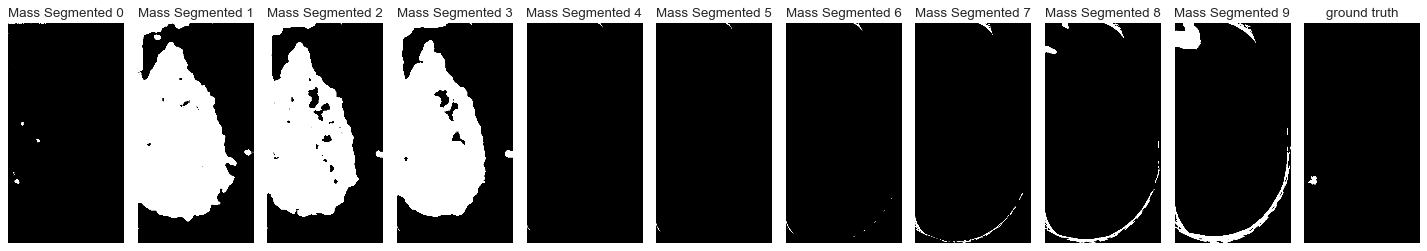

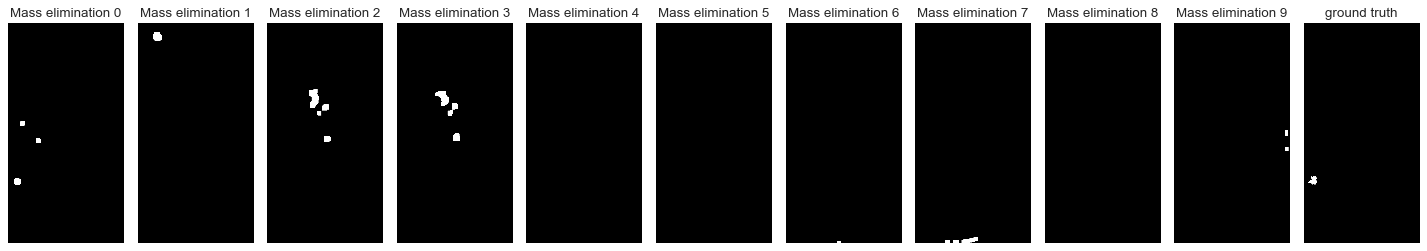

In [14]:
# Highest! 0.7094017094017094

def mean_shift_filter(image, spatial_radius=15, range_radius=60):
    """
    Apply mean shift filter to a grayscale image.

    Parameters:
    - image: 2D numpy array of type uint16 with shape (height, width)
    - spatial_radius: int, spatial distance (in pixels) to consider for the filter
    - range_radius: int, color distance to consider for the filter

    Returns:
    - filtered_image: 2D numpy array of type uint16 with shape (height, width),
                      the result of the filter
    """

    # Convert image to float32 for better precision
    image_float = image.astype(np.float32)

    # Convert image to uint8 for OpenCV
    image_uint8 = cv2.convertScaleAbs(image_float / np.max(image_float) * 255)

    # Convert 2-channel grayscale image to 3-channel grayscale image
    image_3ch = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2BGR)

    # Apply mean shift filter using OpenCV
    filtered_image_uint8 = cv2.pyrMeanShiftFiltering(image_3ch, spatial_radius, range_radius)

    # Convert the filtered image back to uint16
    filtered_image_float = cv2.cvtColor(filtered_image_uint8, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0 * np.max(image_float)
    filtered_image = filtered_image_float.astype(np.uint16)

    return filtered_image

def eliminate_thin_lines(image):
    # Convert the image to grayscale if necessary
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply binary thresholding to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Define the kernel for morphological operations
    kernel = np.ones((15, 15), np.uint8)

    # Perform opening operation
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return opened

def eliminate(image):
    
    # Normalize the filtered image to improve contrast
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Perform adaptive thresholding on the normalized image
    thresh = cv2.adaptiveThreshold(normalized_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 2)
#     _, thresh = cv2.threshold(normalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Perform morphological operations
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
#     closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
#     # Perform morphological opening to eliminate remaining small objects
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
#     opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    # Find contours of thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank image to draw contours on
    result = np.zeros_like(thresh)
    
    min_area = 110
    max_area = 551132

    # Loop through contours and eliminate those outside the desired area range
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area and area < max_area:
            cv2.drawContours(result, [cnt], 0, (255, 255, 255), -1)
            
    threshold = 128
    _, binary_result = cv2.threshold(eliminate_thin_lines(result), threshold, 255, cv2.THRESH_BINARY)


    return binary_result

def kmeans(input_img):
    try:        
        # convert to float & reshape to a [1 x W*H] Mat
        # (so every pixel is on a row of its own)
        data = input_img.astype(np.float32)
        data = data.reshape(1, -1)

        # do kmeans
        _, labels, centers = cv2.kmeans(
            data, 2, None,
            criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0),
            attempts=15,
            flags=cv2.KMEANS_PP_CENTERS
        )

        # replace pixel values with their center value:
        p = data[0]
        for i in range(data.shape[1]):
            center_id = labels[i]
            p[i] = centers[center_id]

        # back to 2D, and uchar:
        img = data.reshape(input_img.shape)
        img = np.clip(img, 0, 65535).astype(np.uint16)
        
        # Normalize the filtered image to improve contrast
        

        # Perform adaptive thresholding on the normalized image
#         img = cv2.adaptiveThreshold(normalized_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 2)        
#         _, img = cv2.threshold(normalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return img

    except Exception as e:
        print(str(e))


def pipeline(input_image):
    
    sifted_image = mms.multi_scale_morphological_sifters(input_image,10,18,15,3689,70/1000)

    # Apply the mean shift filtering to the different scales of sifted images
    mean_shifted_image_0 = mean_shift_filter(sifted_image[0])
    mean_shifted_image_1 = mean_shift_filter(sifted_image[1])
    mean_shifted_image_2 = mean_shift_filter(sifted_image[2])
    mean_shifted_image_3 = mean_shift_filter(sifted_image[3])
    mean_shifted_image_4 = mean_shift_filter(sifted_image[4])
    mean_shifted_image_5 = mean_shift_filter(sifted_image[5])
    mean_shifted_image_6 = mean_shift_filter(sifted_image[6])
    mean_shifted_image_7 = mean_shift_filter(sifted_image[7])
    mean_shifted_image_8 = mean_shift_filter(sifted_image[8])
    mean_shifted_image_9 = mean_shift_filter(sifted_image[9])
    
    kmean0 = kmeans(mean_shifted_image_0) 
    kmean1 = kmeans(mean_shifted_image_1) 
    kmean2 = kmeans(mean_shifted_image_2) 
    kmean3 = kmeans(mean_shifted_image_3)
    kmean4 = kmeans(mean_shifted_image_4) 
    kmean5 = kmeans(mean_shifted_image_5) 
    kmean6 = kmeans(mean_shifted_image_6) 
    kmean7 = kmeans(mean_shifted_image_7) 
    kmean8 = kmeans(mean_shifted_image_8) 
    kmean9 = kmeans(mean_shifted_image_9)

    mass0 = eliminate(kmean0) 
    mass1 = eliminate(kmean1) 
    mass2 = eliminate(kmean2) 
    mass3 = eliminate(kmean3)
    mass4 = eliminate(kmean4) 
    mass5 = eliminate(kmean5) 
    mass6 = eliminate(kmean6) 
    mass7 = eliminate(kmean7)
    mass8 = eliminate(kmean8) 
    mass9 = eliminate(kmean9)
    
    
    return sifted_image, [mean_shifted_image_0, mean_shifted_image_1, mean_shifted_image_2, mean_shifted_image_3, mean_shifted_image_4, mean_shifted_image_5, mean_shifted_image_6, mean_shifted_image_7, mean_shifted_image_8, mean_shifted_image_9], [kmean0, kmean1, kmean2, kmean3, kmean4, kmean5, kmean6, kmean7, kmean8, kmean9], \
            [mass0, mass1, mass2, mass3, mass4, mass5, mass6, mass7, mass8, mass9]

# image_input_name = '20586908_6c613a14b80a8591_MG_R_CC_ANON.tif'
# image_input_name = '22580341_5eae9beae14d26fd_MG_R_CC_ANON.tif'
# image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'
# image_input_name = '53586869_6ac23356b912ee9b_MG_L_ML_ANON.tif'
# image_input_name = '22670324_98429c0bdf78c0c7_MG_R_ML_ANON.tif'

# image_input_name = '20587902_8dbbd4e51f549ff0_MG_R_CC_ANON.tif'
# image_input_name = '20588046_024ee3569b2605dc_MG_R_ML_ANON.tif'

image_input_name = '24055445_ac3185e18ffdc7b6_MG_L_ML_ANON.tif'
# image_input_name = '50995762_0c735e8768d276b4_MG_R_ML_ANON.tif'


input_image = cv2.imread(
    os.path.join(
        os.path.dirname("../dataset/processed/positive_images/"), 
        image_input_name
    ), cv2.IMREAD_UNCHANGED)

sifted_image, [mean_shifted_image_0, mean_shifted_image_1, mean_shifted_image_2, mean_shifted_image_3, mean_shifted_image_4, mean_shifted_image_5, mean_shifted_image_6, mean_shifted_image_7, mean_shifted_image_8, mean_shifted_image_9], \
            [kmean0, kmean1, kmean2, kmean3, kmean4, kmean5, kmean6, kmean7, kmean8, kmean9], \
            [mass0, mass1, mass2, mass3, mass4, mass5, mass6, mass7, mass8, mass9] = pipeline(input_image)


imgs = {
    "MMs sifted_image[0]": sifted_image[0],
    "MMs sifted_image[1]": sifted_image[1],
    "MMs sifted_image[2]": sifted_image[2],
    "MMs sifted_image[3]": sifted_image[3],
    
    "MMs sifted_image[4]": sifted_image[4],
    "MMs sifted_image[5]": sifted_image[5],
    "MMs sifted_image[6]": sifted_image[6],
    "MMs sifted_image[7]": sifted_image[7],
    
    "MMs sifted_image[8]": sifted_image[8],
    "MMs sifted_image[9]": sifted_image[9],
    "ground truth": cv2.imread(f'../dataset/processed/groundtruth/{image_input_name}', cv2.IMREAD_UNCHANGED)
    } # 15, 100
display.plot_figures(imgs, 1, 11)

imgs = {
    "Mean Shift Filter Scale 0": mean_shifted_image_0,
    "Mean Shift Filter Scale 1": mean_shifted_image_1,
    "Mean Shift Filter Scale 2": mean_shifted_image_2,
    "Mean Shift Filter Scale 3": mean_shifted_image_3,
    "Mean Shift Filter Scale 4": mean_shifted_image_4,
    "Mean Shift Filter Scale 5": mean_shifted_image_5,
    "Mean Shift Filter Scale 6": mean_shifted_image_6,
    "Mean Shift Filter Scale 7": mean_shifted_image_7,
    "Mean Shift Filter Scale 8": mean_shifted_image_8,
    "Mean Shift Filter Scale 9": mean_shifted_image_9,
    "ground truth": cv2.imread(f'../dataset/processed/groundtruth/{image_input_name}', cv2.IMREAD_UNCHANGED)
    } # 15, 100
display.plot_figures(imgs, 1, 11)


imgs = {
    "Mass Segmented 0": kmean0,
    "Mass Segmented 1": kmean1,
    "Mass Segmented 2": kmean2,
    "Mass Segmented 3": kmean3,
    "Mass Segmented 4": kmean4,
    "Mass Segmented 5": kmean5,
    "Mass Segmented 6": kmean6,
    "Mass Segmented 7": kmean7,
    "Mass Segmented 8": kmean8,
    "Mass Segmented 9": kmean9,
    "ground truth": cv2.imread(f'../dataset/processed/groundtruth/{image_input_name}', cv2.IMREAD_UNCHANGED)
    } # 15, 100
display.plot_figures(imgs, 1, 11)


imgs = {
    "Mass elimination 0": mass0,
    "Mass elimination 1": mass1,
    "Mass elimination 2": mass2,
    "Mass elimination 3": mass3,
    "Mass elimination 4": mass4,
    "Mass elimination 5": mass5,
    "Mass elimination 6": mass6,
    "Mass elimination 7": mass7,
    "Mass elimination 8": mass8,
    "Mass elimination 9": mass9,
    "ground truth": cv2.imread(f'../dataset/processed/groundtruth/{image_input_name}', cv2.IMREAD_UNCHANGED)
    } # 15, 100
display.plot_figures(imgs, 1, 11)

In [11]:
# def eliminate_by_area_modif(image, min_area, max_area):
#         # Convert to uint8
#         image = (image / np.max(image) * 255).astype(np.uint8)
# #         image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

#         # Apply mean shift filtering to enhance tumor features
#         filtered = mean_shift_filter(image, spatial_radius=45, range_radius=60)
# #         binary_image, gray_clustered = seg.kmeans(image)


#         # Normalize the filtered image to improve contrast
#         normalized_image = cv2.normalize(filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#         # Apply thresholding
# #         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         _, thresh = cv2.threshold(normalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# #         thresh = cv2.adaptiveThreshold(normalized_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 2)

#         # Perform morphological operations
#         kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
#         opened = cv2.morphologyEx(cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

#         # Find contours of thresholded image
#         contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # Create a blank image to draw contours on
#         result = np.zeros_like(opened)

#         # Loop through contours and eliminate those outside the desired area range
#         for cnt in contours:
#             area = cv2.contourArea(cnt)
#             if min_area < area < max_area:
#                 cv2.drawContours(result, [cnt], 0, (255, 255, 255), -1)
                
#         # remove any lines resulted from the contours by performing morphological opening to remove lines
#         kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 25))
        
#         result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)

#         return result


# image_input_name = '22613702_dcafa6ba6374ec07_MG_L_ML_ANON.tif'

# input_image = cv2.imread(
#     os.path.join(
#         os.path.dirname("../dataset/processed/positive_images/"), 
#         image_input_name
#     ), cv2.IMREAD_GRAYSCALE)

# sifted_image = mms.multi_scale_morphological_sifters(input_image,4,18,15,3689,70/1000)

# # Find the average min and max area of mass sizes from the ground truth, calculate pixel wise and update the function call 
# mass0 = eliminate_by_area_modif(sifted_image[0], min_area=800, max_area=50000.0) 
# mass1 = eliminate_by_area_modif(sifted_image[1], min_area=800, max_area=50000.0) 
# mass2 = eliminate_by_area_modif(sifted_image[2], min_area=800, max_area=50000.0) 
# mass3 = eliminate_by_area_modif(sifted_image[3], min_area=800, max_area=50000.0) 

# # Display the enhanced and tophat image
# imgs = {
#     "mass0":mass0,
#     "mass1":mass1,
#     "mass2":mass2,
#     "mass3":mass3
# }
# display.plot_figures(imgs, 2, 2)

In [12]:
# Instead of MLO Thresholding
# superpixels - non-parametric approach
# k means clusturing - K levels
# means clusturing - reguarization params


# Features extraction
# GLCM features 10-15 + statistics of mass region (contrast average value)

# Shape features 10
# LBP 
# SIFTs

# Gabor wavelets ~ good to charectirize textures in iris


# Features reduction - LDA 

In [ ]:
# # Set the paths to the positive images and groundtruth folders
# positive_images_path = '../dataset/positive_images'
# groundtruth_path = '../dataset/groundtruth'

# # Get a list of all the tif images in the positive images folder
# tif_images = [f for f in os.listdir(positive_images_path) if f.endswith('.tif')]

In [ ]:
# tif_images

In [ ]:
# def mean_shift_filter(image, spatial_radius=40, color_radius=80):
#     # Normalize the image to the range [0, 255]
#     normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
#     # Convert the image to BGR color space
#     bgr_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
    
#     # Apply mean shift filtering
#     filtered_image = cv2.pyrMeanShiftFiltering(bgr_image, spatial_radius, color_radius)
    
#     # Convert the filtered image to grayscale
#     grayscale_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    
#     return grayscale_image

In [ ]:
# plt.rcParams['figure.max_open_warning'] = False

# for image_input_name in tif_images:

#     normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
#         image_input_name, 
#         plot=False,
#     )

#     # Reading the same processed image (ovarlayed version) for visual comparison
#     overlay_image_dataset = os.path.join(mms.overlay_dir, image_input_name)
#     overlay_image = cv2.imread(overlay_image_dataset)

#     # Display the enhanced and tophat image
#     imgs = {
#         "MMs enhanced scale 0": enhanced_images[0],
#         "MMs scale 0 filtered": mean_shift_filter(enhanced_images[0]),
#         "MMs enhanced scale 1": enhanced_images[1],
#         "MMs scale 1 filtered": mean_shift_filter(enhanced_images[1]),
#         "MMS normalized summed image": normalized_image,
#         "MMs scale 0 filtered": mean_shift_filter(normalized_image)
# #         "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
#     }
#     display.plot_figures(imgs, 2, 3)

Savving all MMs scales and summed images in a directory

In [11]:
# mms_output_dir = r"..\\dataset\\output\\mms"
# segmentation_output_dir = r"..\\dataset\\output\\segmentation"

# if not os.path.isdir(mms_output_dir):
#     os.makedirs(mms_output_dir)
#     logger.info(f"New directory created '{mms_output_dir}'")
    
# if not os.path.isdir(segmentation_output_dir):
#     os.makedirs(segmentation_output_dir)
#     logger.info(f"New directory created '{segmentation_output_dir}'")

In [109]:
# # RUN ONLY ONCE
# positive_images_dir = r"..\\dataset\\positive_images"

# for idx, file_name in tqdm(enumerate(os.listdir(positive_images_dir))):
#     file_dir = ''

#     input_image = cv2.imread(
#         os.path.join(
#             os.path.dirname("../dataset/processed/positive_images/"), 
#             file_name
#         ), cv2.IMREAD_UNCHANGED)
    
#     sifted_image = mms.multi_scale_morphological_sifters(input_image,4,18,15,3689,70/1000)    
    
#     for index, img in enumerate(sifted_image):
#         # Scale i image will have a file name tailed with _i        
#         file_dir = os.path.join(mms_output_dir, file_name.split('.tif')[0] + '_' + str(index) + '.tif')
#         cv2.imwrite(file_dir, sifted_image[index].astype(np.uint16))
        


107it [00:39,  2.72it/s]
